In [1]:
import matplotlib.pyplot as plt

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


### load packages

In [4]:
from tfumap.umap import tfUMAP

/home/AD/tsainbur/anaconda3/envs/scvis2/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

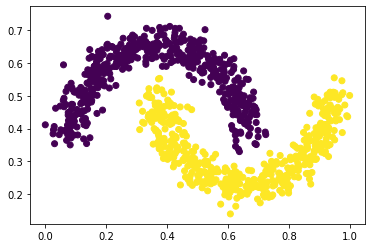

In [6]:
from sklearn.datasets import make_moons

X_train, Y_train = make_moons(1000, random_state=0, noise=0.1)

X_test, Y_test = make_moons(1000, random_state=1, noise=0.1)

X_valid, Y_valid = make_moons(1000, random_state=2, noise=0.1)

def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

X_train = norm(X_train)
X_valid = norm(X_valid)
X_test = norm(X_test)
X_train_flat = X_train

X_test_flat = X_test

plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)

### Create model and train

In [7]:
from scvis.run import train, map

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [8]:
from scvis.model import SCVIS

In [9]:
x = X_train_flat

In [10]:
hyperparameter =  {
  'optimization': {
    'method': 'Adam',
    'learning_rate': 0.01
  },

  'batch_size': 512,
  'max_epoch': 100,
  'regularizer_l2': 0.001,

  'perplexity': 10,

  'seed': 1
}

architecture = {
  'latent_dimension': 2,

  'inference': {
    'layer_size': [128, 64, 32],
  },

  'model': {
    'layer_size': [32, 32, 32, 64, 128],
  },

  'activation': "ELU"
}

In [11]:
architecture.update({'input_dimension': x.shape[1]})

In [12]:
model = SCVIS(architecture, hyperparameter)




Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [13]:
y = None

In [14]:
from scvis import data


In [15]:
train_data = data.DataSet(x, y)

In [16]:
es = model.train(data=train_data,
                      batch_size=hyperparameter['batch_size'],
                      verbose=True,
                      verbose_interval=50,
                      show_plot=False,
                      plot_dir=None,
                      max_iter=1000,
                      pretrained_model=None)


Batch 0
elbo: -9.524543762207031
scaled_tsne_cost: 6.3732709884643555

Batch 50
elbo: -1.5335125923156738
scaled_tsne_cost: 10.378032684326172

Batch 100
elbo: -2.2599949836730957
scaled_tsne_cost: 10.091766357421875

Batch 150
elbo: -0.15985476970672607
scaled_tsne_cost: 10.023813247680664

Batch 200
elbo: -1.6404458284378052
scaled_tsne_cost: 9.28005599975586

Batch 250
elbo: -0.1536526083946228
scaled_tsne_cost: 9.335044860839844

Batch 300
elbo: 0.657252311706543
scaled_tsne_cost: 9.097572326660156

Batch 350
elbo: -0.23532253503799438
scaled_tsne_cost: 9.475671768188477

Batch 400
elbo: 1.1714980602264404
scaled_tsne_cost: 9.584980010986328

Batch 450
elbo: 1.3728861808776855
scaled_tsne_cost: 9.2108736038208

Batch 500
elbo: 0.4065514802932739
scaled_tsne_cost: 9.505486488342285

Batch 550
elbo: 1.9125913381576538
scaled_tsne_cost: 9.041196823120117

Batch 600
elbo: -0.11371874809265137
scaled_tsne_cost: 8.92919635772705

Batch 650
elbo: 0.7050905227661133
scaled_tsne_cost: 9.29

In [17]:
z, _ = model.encode(x)

### Plot model output

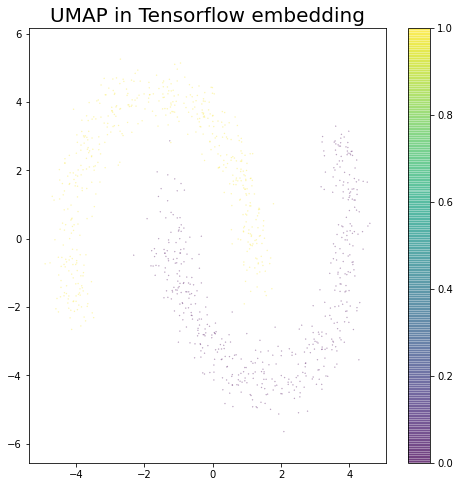

In [18]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train[:len(z)],
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save output

In [19]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [20]:
output_dir = MODEL_DIR/'projections'/ 'moons' / 'scvis'
ensure_dir(output_dir)

In [21]:
np.save(output_dir / 'z.npy', z)